In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from IPython.display import display

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import KFold

C:\Users\Arseny\AppData\Local\Temp\ipykernel_18840\2023018592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


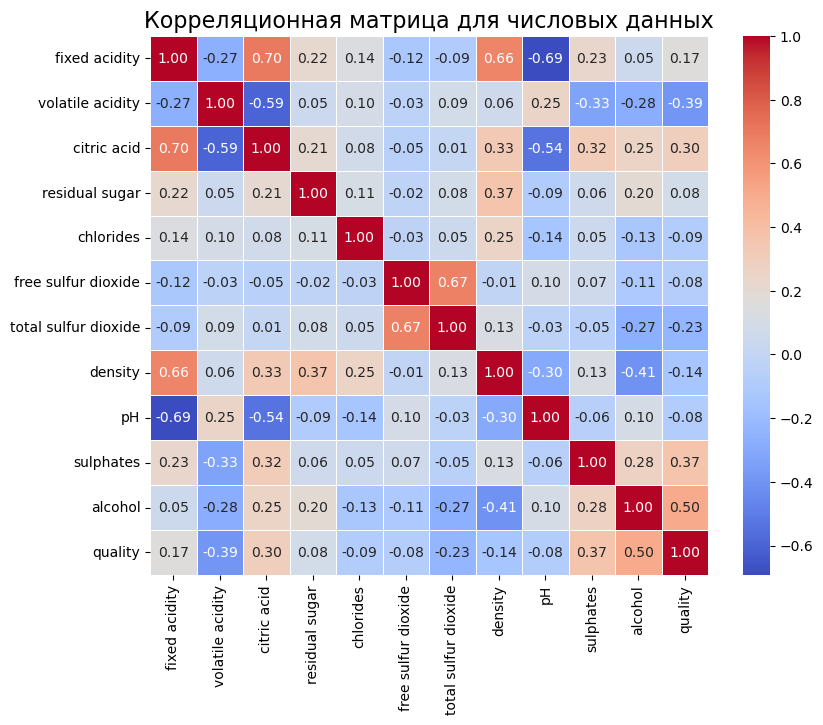

In [2]:
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3, stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
z = stats.zscore(train_data)
train_data_clean = train_data[~(np.abs(z) > 3).any(axis=1)]
#.drop(axis=1, columns=['citric acid'])
numeric_columns = train_data_clean.select_dtypes(include=['float64', 'uint64', 'int64'])
correlation_matrix = numeric_columns.corr(method = 'pearson')
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица для числовых данных', fontsize=16)
plt.show()

In [3]:
train_data_clean.reset_index(inplace=True, drop=True)
target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
features_train = train_data_clean.drop(axis=1, columns=['quality'])
features_test = test_data.drop(axis=1, columns=['quality'])
# .drop(axis=1, columns=['quality', 'citric acid'])

In [4]:
cv = KFold(n_splits=7, random_state=1, shuffle=True)
pipe_svc = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

#шаблон контейнера
C=np.array([380, 450, 650, 1000])
gamma=[0.06, 0.07, 0.08, 0.09]
kernel=['rbf']

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
     'classifier': [svm.SVC()],
     'classifier__C': C,
     'classifier__gamma': gamma,
     'classifier__kernel': kernel
     }
]

grid = GridSearchCV(pipe_svc, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring='precision')
grid.fit(features_train, target_train)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
# print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.precision_score(grid.predict(features_test), target_test)))
gridresults = pd.DataFrame(grid.cv_results_) #лучшая опция по кроссвалидации
display(gridresults.sort_values(["rank_test_score"]).T)

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': SVC(), 'classifier__C': 380, 'classifier__gamma': 0.06, 'classifier__kernel': 'rbf', 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.653061



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,42,45,24,18,6,15,3,12,33,...,19,40,32,25,35,28,37,41,44,47
mean_fit_time,0.075671,0.104024,0.127375,0.092206,0.085584,0.069539,0.07837,0.066087,0.070652,0.087089,...,0.099037,0.085472,0.156208,0.125079,0.147392,0.102022,0.114238,0.188996,0.162167,0.153758
std_fit_time,0.00547,0.006389,0.014998,0.023292,0.014746,0.007032,0.008724,0.008477,0.012272,0.008104,...,0.019044,0.01418,0.015369,0.021938,0.033577,0.011162,0.021256,0.036062,0.028068,0.027624
mean_score_time,0.048057,0.04911,0.043367,0.052572,0.043998,0.043764,0.050964,0.053357,0.058414,0.04813,...,0.042787,0.037771,0.043125,0.041129,0.04997,0.048357,0.03722,0.042456,0.041842,0.040456
std_score_time,0.003271,0.008738,0.003744,0.013212,0.00423,0.003381,0.009216,0.017643,0.023718,0.009172,...,0.005646,0.005663,0.004625,0.002515,0.010126,0.009466,0.00251,0.007442,0.004401,0.002699
param_classifier,SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),...,SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC(),SVC()
param_classifier__C,380,1000,1000,650,450,380,450,380,450,650,...,450,1000,650,650,650,650,1000,1000,1000,1000
param_classifier__gamma,0.06,0.08,0.09,0.06,0.08,0.08,0.07,0.07,0.06,0.09,...,0.08,0.07,0.08,0.06,0.09,0.07,0.06,0.07,0.08,0.09
param_classifier__kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf
param_preprocessing,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler()
params,"{'classifier': SVC(), 'classifier__C': 380, 'c...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 650, 'c...","{'classifier': SVC(), 'classifier__C': 450, 'c...","{'classifier': SVC(), 'classifier__C': 380, 'c...","{'classifier': SVC(), 'classifier__C': 450, 'c...","{'classifier': SVC(), 'classifier__C': 380, 'c...","{'classifier': SVC(), 'classifier__C': 450, 'c...","{'classifier': SVC(), 'classifier__C': 650, 'c...",...,"{'classifier': SVC(), 'classifier__C': 450, 'c...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 650, 'c...","{'classifier': SVC(), 'classifier__C': 650, 'c...","{'classifier': SVC(), 'classifier__C': 650, 'c...","{'classifier': SVC(), 'classifier__C': 650, 'c...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 1000, '...","{'classifier': SVC(), 'classifier__C': 1000, '..."


Правильность для наилучшей модели на тестовом наборе: 0.769231



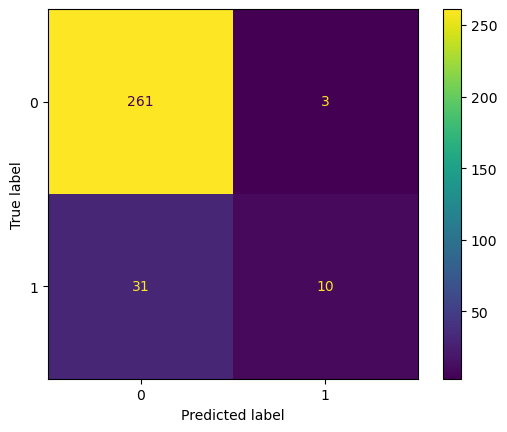

In [5]:
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, grid.predict(features_test))))
matrix = confusion_matrix(target_test, grid.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

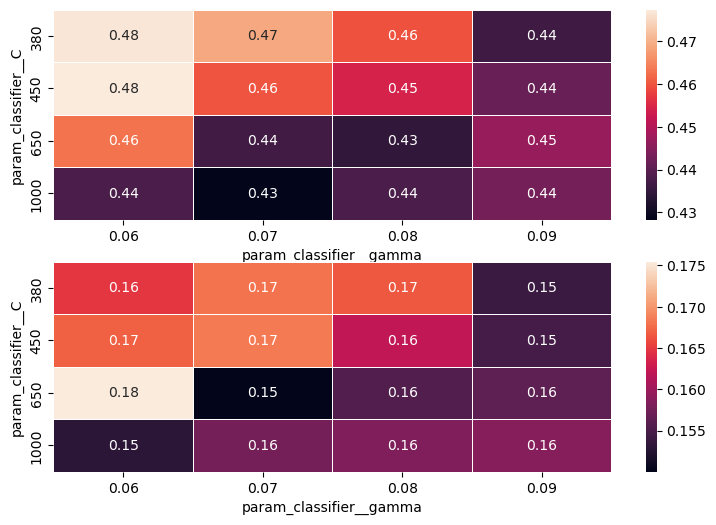

In [6]:
table=pd.DataFrame(grid.cv_results_)
pv_table=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
pv_table_std=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='std_test_score')
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax1);
sns.heatmap(pv_table_std, annot=True, linewidths=.5, ax=ax2);

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Правильность модели на тестовом наборе: 0.769231

recall:  0.317  precision:, 0.722  thresholds:,0.418
recall:  0.220  precision:, 0.818  thresholds:,0.489


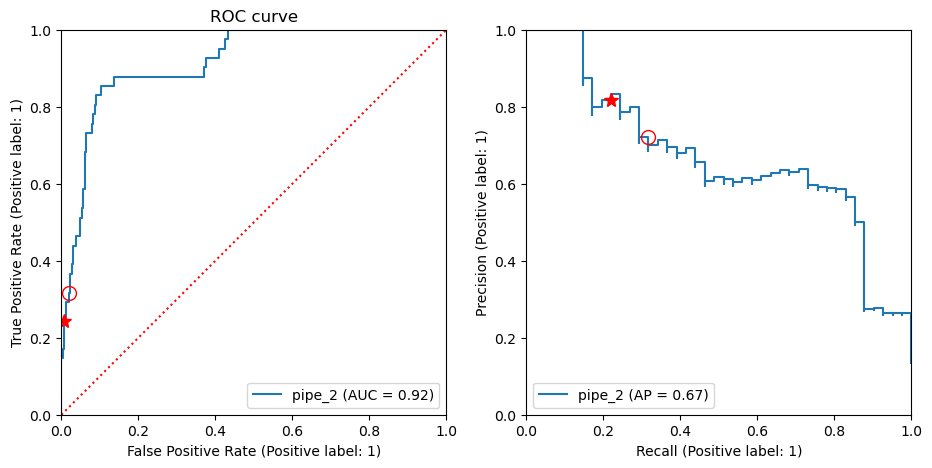

In [10]:
pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.06, C=380, probability=True, kernel='rbf'))
pipe_1.fit(features_train,target_train)
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 10
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [61]:
# from sklearn.preprocessing import PolynomialFeatures

In [62]:
# poly = PolynomialFeatures(degree=2, interaction_only=False)

In [63]:
# list_pr=[]
# path_train = 'train.csv'
# data = pd.read_csv(path_train)
# data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
# only_na = data[~data.index.isin(data_no_na.index)]
# data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
# no_duplicates = data_no_na.drop_duplicates(keep='first')
# only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
# for i in range(100):
#         train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
#                                                                         stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
#         z = stats.zscore(train_data)
#         train_data_clean = train_data.drop(axis=1, columns=['citric acid'])#[~(np.abs(z) > 3).any(axis=1)]
#         train_data_clean.reset_index(inplace=True, drop=True)
#         target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
#         features_train = train_data_clean.drop(axis=1, columns=['quality'])
#         features_test = test_data.drop(axis=1, columns=['quality', 'citric acid'])
#         features_train_poly = poly.fit_transform(features_train)
#         features_test_poly = poly.fit_transform(features_test)
#         pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
#         pipe_1.fit(features_train_poly,target_train.values.ravel())
#         list_pr.append(precision_score(target_test, pipe_1.predict(features_test_poly), zero_division=0))
# print(f'Скор для полиномов...скор: {sum(list_pr)/100}')
# print(features_test_poly.shape)

In [71]:
list_preds=[]
col_names=['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
# for j in col_names:
#     list_preds=[]
#     for i in range(10):
#         train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
#                                                                         stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
#         z = stats.zscore(train_data)
#         train_data_clean = train_data.drop(axis=1, columns=['citric acid', j])#[~(np.abs(z) > 3).any(axis=1)]
#         train_data_clean.reset_index(inplace=True, drop=True)
#         target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
#         features_train = train_data_clean.drop(axis=1, columns=['quality'])
#         features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', j])
#         pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
#         pipe_1.fit(features_train,target_train.values.ravel())
#         list_preds.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
#     print(f'Дроп строки {j}...скор: {sum(list_preds)/10}')
#     del list_preds

no_citr=[]
for i in range(100):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['quality']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid'])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid'])
        pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
        pipe_1.fit(features_train,target_train.values.ravel())
        no_citr.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
print(f'Дроп строки citric и dinsity ...скор: {sum(no_citr)/100}')

C:\Users\Arseny\AppData\Local\Temp\ipykernel_20128\2459231612.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


Дроп строки citric и dinsity ...скор: 0.6095771150590038


In [50]:
# def custom_predict(X, threshold):
#     probs = model.predict_proba(X) 
#     return (probs[:, 1] > threshold).astype(int)
    
    
# new_preds = custom_predict(X=X, threshold=0.4) 

1) В случае если мы не делаем чисту выбросов, но удаляем citric acid, то в 12 pose получается 0.75 0.44
2) В случае если мы не дропаем, то в pos=10 получается 0.78, 0.44
3) Пока лучше всего работает с neighbors=30, p=4, weight='distance'